## Car Escape with Infeasible State Trajectory Initialization

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra, ForwardDiff

┌ Info: Recompiling stale cache file /home/taylor/.julia/compiled/v1.1/TrajectoryOptimization/UVgeA.ji for TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1184
┌ Warning: Package TrajectoryOptimization does not have MatrixCalculus in its dependencies:
│ - If you have TrajectoryOptimization checked out for development and have
│   added MatrixCalculus as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TrajectoryOptimization
└ Loading MatrixCalculus into TrajectoryOptimization from project dependency, future warnings for TrajectoryOptimization are suppressed.


Import the car model

In [2]:
model = Dynamics.car_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [3]:
T = Float64;

Define initial and goal states

In [4]:
x0 = [2.5;2.5;0.]
xf = [7.5;2.5;0.]

3-element Array{Float64,1}:
 7.5
 2.5
 0.0

Define a cost function, e.g., quadratic

In [5]:
Qf = 100.0*Diagonal(I,n)
Q = (1e-3)*Diagonal(I,n)
R = (1e-2)*Diagonal(I,m)
_cost = LQRCost(Q,R,Qf,xf);

Define constraints

In [6]:
u_min = [-5.; -5.]
u_max = [5.; 5.]
bnd = bound_constraint(n,m,u_min=u_min,u_max=u_max,trim=true)

goal = goal_constraint(xf)

TerminalConstraint{Equality}(getfield(TrajectoryOptimization, Symbol("#terminal_constraint#36")){Array{Float64,1}}([7.5, 2.5, 0.0]), getfield(TrajectoryOptimization, Symbol("#terminal_jacobian#37")){Int64}(3), 3, :goal, Array{Int64,1}[[1, 2, 3]])

Construct trap constraint

In [7]:
r = 0.5
s1 = 30; s2 = 50; s3 = 15

circles_escape = []

for i in range(0,stop=5,length=s1)
    push!(circles_escape,(0.,i,r))
end
for i in range(0,stop=5,length=s1)
    push!(circles_escape,(5.,i,r))
end
for i in range(0,stop=5,length=s1)
    push!(circles_escape,(10.,i,r))
end
for i in range(0,stop=10,length=s2)
    push!(circles_escape,(i,0.,r))
end
for i in range(0,stop=3,length=s3)
    push!(circles_escape,(i,5.,r))
end
for i in range(5,stop=8,length=s3)
    push!(circles_escape,(i,5.,r))
end

n_circles_escape = 3*s1 + s2 + 2*s3

function cI_escape(c,x,u)
    for i = 1:n_circles_escape
        c[i] = TrajectoryOptimization.circle_constraint(x,circles_escape[i][1],circles_escape[i][2],circles_escape[i][3])
    end
end

cI_wrap(c,z) = cI_escape(c,z[1:n],z[n .+ (1:m)])

ForwardDiff.jacobian(cI_wrap,zeros(n_circles_escape),rand(n+m))

function ∇cI_escape(C,x,u)
    copyto!(C,ForwardDiff.jacobian(cI_wrap,zeros(n_circles_escape),[x;u]))
end

trap = Constraint{Inequality}(cI_escape,∇cI_escape,n,m,n_circles_escape,:trap);

Create constraint set

In [8]:
con = [bnd,trap,goal];

Set options

In [9]:
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=false,live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=false,opts_uncon=opts_ilqr,
    cost_tolerance=1.0e-4,cost_tolerance_intermediate=1.0e-2,constraint_tolerance=1.0e-3,penalty_scaling=10.,penalty_initial=1.)

opts_altro = TrajectoryOptimization.ALTROSolverOptions{T}(verbose=false,opts_al=opts_al,R_inf=1.0);

Define a problem

In [10]:
N = 101
tf = 3.0
U = [ones(m) for k = 1:N-1]
obj = Objective(_cost,N)
constraints = TrajectoryOptimization.ProblemConstraints(con,N)

prob = Problem(model,obj,constraints=constraints,N=N,tf=tf,x0=x0)
initial_controls!(prob, U);


Infeasible state trajectory

In [11]:
X_guess = [2.5 2.5 0.;4. 5. .785;5. 6.25 0.;7.5 6.25 -.261;9 5. -1.57;7.5 2.5 0.]
X0 = TrajectoryOptimization.interp_rows(N,tf,Array(X_guess'));

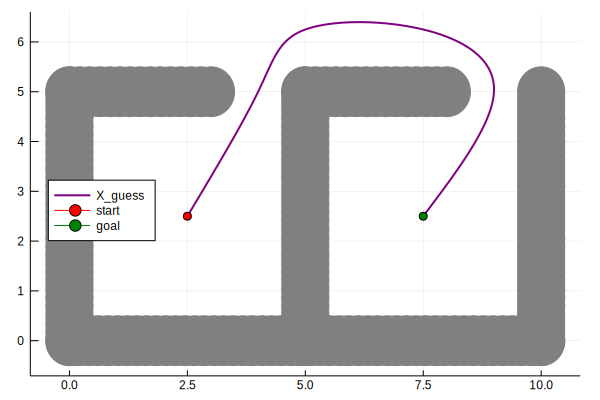

In [12]:
plot(labels="")
plot_obstacles(circles_escape,:grey)
plot!(X0[1,:],X0[2,:],width=2,color=:purple,label="X_guess")
plot!((x0[1],x0[1]),marker=:circle,color=:red,label="start")
plot!((xf[1],xf[2]),marker=:circle,color=:green,label="goal",legend=:left)

Initialize problem with state trajectory

In [13]:
copyto!(prob.X,X0);

Solve problem

In [ ]:
solve!(prob, opts_altro) # solve with ALTRO

Plot state trajectories

In [ ]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N];

In [ ]:
plot(labels="")
plot_obstacles(circles_escape,:grey)
plot!(X0[1,:],X0[2,:],width=2,color=:purple,label="X_guess")
plot!(x,y,width=2,color=:blue,label="ALTRO")
plot!((x0[1],x0[1]),marker=:circle,color=:red,label="start")
plot!((xf[1],xf[2]),marker=:circle,color=:green,label="goal",legend=:left)